# Question 1

In [5]:
import math
from functools import lru_cache
import sys

# Increase recursion limit
sys.setrecursionlimit(10000)

# Daily discount factor computed from an annual interest rate of 17%
beta = 1 / (1 + 0.17 / 365)

# Define the possible pricing decisions: each tuple is (coach_price, first_class_price)
decisions = [(300, 425), (300, 500), (350, 425), (350, 500)]

def binom_pmf(n, k, p):
    """Compute the binomial probability mass function."""
    return math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k))

def compute_terminal_cost(s_c, s_f):
    """
    Compute the expected overbooking cost when the flight departs.

    Parameters:
      s_c: total coach tickets sold (max 105 allowed)
      s_f: total first-class tickets sold (max 20 allowed)

    For coach, let X ~ Binom(s_c, 0.95) be the number of ticket holders who show up.
    For first-class, let Y ~ Binom(s_f, 0.97) be the number who show up.
    Coach overbooking occurs if X > 100.
    Available first-class seats for bumped coach passengers are: free_fc = max(20 - Y, 0).

    The cost is:
      cost = (min(overflow, free_fc) * $50) + (max(overflow - free_fc, 0) * $425)
    """
    expected_cost = 0.0
    # Iterate over all possible show-up counts for coach tickets (0 to s_c)
    for x in range(s_c + 1):
        prob_x = binom_pmf(s_c, x, 0.95)
        # Iterate over all possible show-up counts for first-class tickets (0 to s_f)
        for y in range(s_f + 1):
            prob_y = binom_pmf(s_f, y, 0.97)
            # Calculate available first-class seats to cover coach overflow
            free_fc = max(20 - y, 0)
            # Calculate overflow if more than 100 coach passengers show up
            overflow = max(x - 100, 0)
            # Calculate cost: free FC seats cost $50 each, additional bumped passengers cost $425 each
            cost = min(overflow, free_fc) * 50 + max(overflow - free_fc, 0) * 425
            # Accumulate expected cost weighted by the probability of the outcome
            expected_cost += prob_x * prob_y * cost
    return expected_cost

@lru_cache(maxsize=None)
def V(d, s_c, s_f):
    """
    Recursively compute the maximum expected discounted profit with:
      d   : days remaining until the flight
      s_c : cumulative coach tickets sold
      s_f : cumulative first-class tickets sold

    At d = 0 (flight day), no revenue is earned; only the overbooking cost is incurred.
    """
    if d == 0:
        # Terminal condition: on flight day, profit is negative due to overbooking cost.
        return -compute_terminal_cost(s_c, s_f)

    best_val = -float('inf')  # Initialize best value to a very small number

    # Loop over each pricing decision available
    for (coach_price, fc_price) in decisions:
        # Adjust the coach sale probability based on whether first-class is full.
        if s_f == 20:
            p_coach = 0.68 if coach_price == 300 else 0.33
        else:
            p_coach = 0.65 if coach_price == 300 else 0.30

        # If maximum coach tickets have been sold (overbooking limit reached), no further coach sales
        if s_c >= 105:
            p_coach = 0

        # Set first-class sale probability based on the price offered.
        p_fc = 0.08 if fc_price == 425 else 0.04
        # If first-class is full, set sale probability to 0.
        if s_f >= 20:
            p_fc = 0

        expected_val = 0.0

        # Outcome 1: No sale occurs in either class.
        prob = (1 - p_coach) * (1 - p_fc)
        revenue = 0
        next_val = V(d - 1, s_c, s_f)
        expected_val += prob * (revenue + beta * next_val)

        # Outcome 2: Only a coach ticket is sold.
        prob = p_coach * (1 - p_fc)
        revenue = coach_price
        next_val = V(d - 1, min(s_c + 1, 105), s_f)
        expected_val += prob * (revenue + beta * next_val)

        # Outcome 3: Only a first-class ticket is sold.
        prob = (1 - p_coach) * p_fc
        revenue = fc_price
        next_val = V(d - 1, s_c, min(s_f + 1, 20))
        expected_val += prob * (revenue + beta * next_val)

        # Outcome 4: Both a coach and a first-class ticket are sold.
        prob = p_coach * p_fc
        revenue = coach_price + fc_price
        next_val = V(d - 1, min(s_c + 1, 105), min(s_f + 1, 20))
        expected_val += prob * (revenue + beta * next_val)

        # Keep the decision that gives the maximum expected value.
        if expected_val > best_val:
            best_val = expected_val

    return best_val

# Starting with 365 days remaining and no tickets sold.
result = V(365, 0, 0)
print("The expected discounted profit for overbooking by 5 seats is: ${:.2f}".format(result))


The expected discounted profit for overbooking by 5 seats is: $41886.16


# Question 2

Overbooking by  6 seats (max coach = 106): Profit = $42,011.22
Overbooking by  7 seats (max coach = 107): Profit = $42,085.54
Overbooking by  8 seats (max coach = 108): Profit = $42,122.17
Overbooking by  9 seats (max coach = 109): Profit = $42,134.62
Overbooking by 10 seats (max coach = 110): Profit = $42,132.90
Overbooking by 11 seats (max coach = 111): Profit = $42,123.67
Overbooking by 12 seats (max coach = 112): Profit = $42,111.03
Overbooking by 13 seats (max coach = 113): Profit = $42,097.42
Overbooking by 14 seats (max coach = 114): Profit = $42,084.11
Overbooking by 15 seats (max coach = 115): Profit = $42,071.74

Best Policy 1: Overbook by 9 seats → Profit = $42,134.62


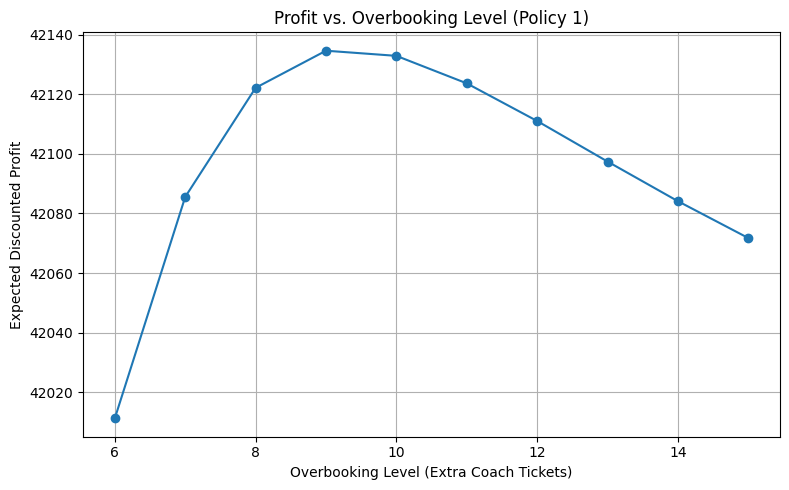

In [6]:
import math
from functools import lru_cache
import sys
import matplotlib.pyplot as plt

# Increase recursion limit
sys.setrecursionlimit(10000)

# Daily discount factor computed from an annual rate of 17%
beta = 1 / (1 + 0.17 / 365)

# Pricing decisions: each tuple represents (coach_price, first_class_price)
decisions = [(300, 425), (300, 500), (350, 425), (350, 500)]

# Compute the binomial probability mass function
def binom_pmf(n, k, p):
    return math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k))

# Compute the expected overbooking cost at flight departure
def compute_terminal_cost(s_c, s_f):
    expected_cost = 0.0
    # Iterate over all possible numbers of coach passengers showing up
    for x in range(s_c + 1):
        prob_x = binom_pmf(s_c, x, 0.95)
        # Iterate over all possible numbers of first-class passengers showing up
        for y in range(s_f + 1):
            prob_y = binom_pmf(s_f, y, 0.97)
            # Free first-class seats available to cover coach overflow
            free_fc = max(20 - y, 0)
            # Coach overflow occurs when more than 100 coach passengers show up
            overflow = max(x - 100, 0)
            # Calculate cost: first use free FC seats at $50, then $425 for additional bumped passengers
            cost = min(overflow, free_fc) * 50 + max(overflow - free_fc, 0) * 425
            expected_cost += prob_x * prob_y * cost
    return expected_cost

# Solve the dynamic programming problem given a maximum number of coach tickets (max_coach)
def solve_policy(max_coach):
    @lru_cache(maxsize=None)
    def V(d, s_c, s_f):
        # Base case: flight day; only terminal cost (negative profit) is incurred
        if d == 0:
            return -compute_terminal_cost(s_c, s_f)

        best_val = -float('inf')
        # Loop over each pricing decision option
        for (coach_price, fc_price) in decisions:
            # Set coach sale probability based on first-class capacity status
            if s_f == 20:
                p_coach = 0.68 if coach_price == 300 else 0.33
            else:
                p_coach = 0.65 if coach_price == 300 else 0.30
            # If maximum coach tickets have been sold, disable further coach sales
            if s_c >= max_coach:
                p_coach = 0

            # Set first-class sale probability based on pricing
            p_fc = 0.08 if fc_price == 425 else 0.04
            # If first-class is full, disable further first-class sales
            if s_f >= 20:
                p_fc = 0

            expected_val = 0.0
            # Outcome 1: No sale occurs in either class
            prob = (1 - p_coach) * (1 - p_fc)
            expected_val += prob * (0 + beta * V(d - 1, s_c, s_f))
            # Outcome 2: Only a coach ticket is sold
            prob = p_coach * (1 - p_fc)
            expected_val += prob * (coach_price + beta * V(d - 1, min(s_c + 1, max_coach), s_f))
            # Outcome 3: Only a first-class ticket is sold
            prob = (1 - p_coach) * p_fc
            expected_val += prob * (fc_price + beta * V(d - 1, s_c, min(s_f + 1, 20)))
            # Outcome 4: Both a coach and a first-class ticket are sold
            prob = p_coach * p_fc
            expected_val += prob * (coach_price + fc_price + beta * V(d - 1, min(s_c + 1, max_coach), min(s_f + 1, 20)))

            # Keep the best expected value over all decisions
            best_val = max(best_val, expected_val)

        return best_val

    # Start the recursion with 365 days remaining and no tickets sold
    return V(365, 0, 0)

# --- Run policy over overbooking levels from 6 to 15 ---
results_policy1 = []
best_policy_level1 = None
best_value_policy1 = -float('inf')

# Overbooking range: extra tickets sold from 6 to 15
overbook_range_policy1 = list(range(6, 16))

# Evaluate the policy for each overbooking level
for extra in overbook_range_policy1:
    max_coach = 100 + extra  # Maximum coach seats available (base 100 plus extra overbooking)
    profit = solve_policy(max_coach)
    results_policy1.append((extra, profit))
    print(f"Overbooking by {extra:2d} seats (max coach = {max_coach}): Profit = ${profit:,.2f}")
    if profit > best_value_policy1:
        best_value_policy1 = profit
        best_policy_level1 = extra
        best_ob1 = best_policy_level1  # Store the best overbooking level for Policy 1

print(f"\nBest Policy 1: Overbook by {best_policy_level1} seats → Profit = ${best_value_policy1:,.2f}")

# Extract values for plotting
overbook_levels_policy1 = [x[0] for x in results_policy1]
profits_policy1 = [x[1] for x in results_policy1]

# Plot expected discounted profit vs. overbooking level
plt.figure(figsize=(8, 5))
plt.plot(overbook_levels_policy1, profits_policy1, marker='o', linestyle='-')
plt.xlabel("Overbooking Level (Extra Coach Tickets)")
plt.ylabel("Expected Discounted Profit")
plt.title("Profit vs. Overbooking Level (Policy 1)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Question 3

Overbooking by  0 → Max coach = 100, Profit = $40,654.29
Overbooking by  1 → Max coach = 101, Profit = $40,942.07
Overbooking by  2 → Max coach = 102, Profit = $41,221.45
Overbooking by  3 → Max coach = 103, Profit = $41,481.58
Overbooking by  4 → Max coach = 104, Profit = $41,707.62
Overbooking by  5 → Max coach = 105, Profit = $41,886.16
Overbooking by  6 → Max coach = 106, Profit = $42,011.22
Overbooking by  7 → Max coach = 107, Profit = $42,085.54
Overbooking by  8 → Max coach = 108, Profit = $42,122.17
Overbooking by  9 → Max coach = 109, Profit = $42,134.62
Overbooking by 10 → Max coach = 110, Profit = $42,138.14
Overbooking by 11 → Max coach = 111, Profit = $42,139.33
Overbooking by 12 → Max coach = 112, Profit = $42,139.71
Overbooking by 13 → Max coach = 113, Profit = $42,139.83
Overbooking by 14 → Max coach = 114, Profit = $42,139.87
Overbooking by 15 → Max coach = 115, Profit = $42,139.89
Overbooking by 16 → Max coach = 116, Profit = $42,139.89
Overbooking by 17 → Max coach =

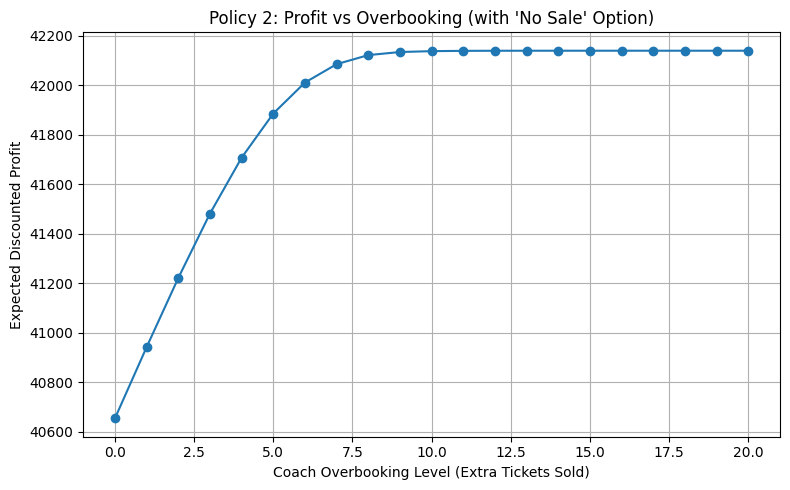

In [1]:
import math
from functools import lru_cache
import sys
import matplotlib.pyplot as plt

# Increase recursion limit to handle deep recursion in the dynamic programming algorithm
sys.setrecursionlimit(10000)

# Daily discount factor computed from an annual 17% rate.
# The discount factor beta represents the present value of one unit of revenue earned one day in the future.
beta = 1 / (1 + 0.17 / 365)

# Define coach decision options:
# Each option is a dictionary containing the action type, sale price, and two probability metrics:
# - base_prob: the probability of a sale under normal conditions.
# - full_fc_prob: the probability of a sale when the first-class section is fully booked.
coach_options = [
    {"action": "low", "price": 300, "base_prob": 0.65, "full_fc_prob": 0.68},
    {"action": "high", "price": 350, "base_prob": 0.30, "full_fc_prob": 0.33},
    {"action": "none", "price": 0, "base_prob": 0.0, "full_fc_prob": 0.0}
]

# Define first-class decision options:
# Each option is a dictionary containing the action type, sale price, and probability of sale.
fc_options = [
    {"action": "low", "price": 425, "prob": 0.08},
    {"action": "high", "price": 500, "prob": 0.04}
]

# Define the binomial probability mass function (PMF).
# This function calculates the probability of k successes in n trials with success probability p.
def binom_pmf(n, k, p):
    return math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k))

# Compute the terminal cost incurred at the end of the booking period.
# This function calculates the expected cost from overselling and possible penalties,
# considering both coach and first-class seats.
def compute_terminal_cost(s_c, s_f):
    expected_cost = 0.0
    # Loop over possible outcomes for coach seat sales
    for x in range(s_c + 1):
        prob_x = binom_pmf(s_c, x, 0.95)
        # Loop over possible outcomes for first-class seat sales
        for y in range(s_f + 1):
            prob_y = binom_pmf(s_f, y, 0.97)
            # Calculate number of free first-class tickets available to cover overflow from coach
            free_fc = max(20 - y, 0)
            # Calculate number of coach passengers that exceed the allowed 100 seats
            overflow = max(x - 100, 0)
            # Calculate cost: first use free first-class tickets at $50 each, then charge $425 for additional tickets
            cost = min(overflow, free_fc) * 50 + max(overflow - free_fc, 0) * 425
            # Accumulate expected cost weighted by the probabilities of the outcomes
            expected_cost += prob_x * prob_y * cost
    return expected_cost

# Function to solve the dynamic programming problem for a given maximum number of coach seats (max_coach)
# with a policy that includes a "no sale" option for coach seats.
def solve_policy_no_coach_sale(max_coach):
    @lru_cache(maxsize=None)
    def V(d, s_c, s_f):
        # Base case: when no days are left, return the negative terminal cost
        if d == 0:
            return -compute_terminal_cost(s_c, s_f)

        best_val = -float('inf')

        # Loop through each coach decision option
        for coach in coach_options:
            # Determine probability of selling a coach seat based on first-class sales status
            if coach["action"] != "none":
                p_coach = coach["full_fc_prob"] if s_f == 20 else coach["base_prob"]
            else:
                p_coach = 0.0
            # If the number of coach seats sold is already at the maximum, no more coach sales are allowed
            if s_c >= max_coach:
                p_coach = 0.0

            # Loop through each first-class decision option
            for fc in fc_options:
                # Determine probability of selling a first-class seat if not already full
                p_fc = fc["prob"] if s_f < 20 else 0.0

                # Calculate joint probabilities for different sale outcomes:
                # - prob_none: neither coach nor first-class sale occurs.
                # - prob_coach_only: only a coach sale occurs.
                # - prob_fc_only: only a first-class sale occurs.
                # - prob_both: both sales occur.
                prob_none = (1 - p_coach) * (1 - p_fc)
                prob_coach_only = p_coach * (1 - p_fc)
                prob_fc_only = (1 - p_coach) * p_fc
                prob_both = p_coach * p_fc

                expected_val = 0.0
                # If no sale occurs, no revenue is collected; update state accordingly.
                expected_val += prob_none * (0 + beta * V(d - 1, s_c, s_f))
                # If only a coach sale occurs, add coach revenue and update state.
                expected_val += prob_coach_only * (coach["price"] + beta * V(d - 1, min(s_c + 1, max_coach), s_f))
                # If only a first-class sale occurs, add first-class revenue and update state.
                expected_val += prob_fc_only * (fc["price"] + beta * V(d - 1, s_c, min(s_f + 1, 20)))
                # If both sales occur, add both revenues and update state.
                expected_val += prob_both * (
                    coach["price"] + fc["price"] +
                    beta * V(d - 1, min(s_c + 1, max_coach), min(s_f + 1, 20))
                )

                # Track the best expected value over all possible decision combinations.
                best_val = max(best_val, expected_val)

        return best_val

    # Start the recursion with 365 days remaining and zero seats sold in both classes.
    return V(365, 0, 0)

# --- Run Policy 2 for all overbooking levels from 0 to 20 ---

profits_policy2 = []
overbook_options_policy2 = list(range(0, 21))

# Evaluate the expected discounted profit for each level of overbooking.
for extra in overbook_options_policy2:
    # The maximum coach seats available is the standard 100 plus the extra overbooked seats.
    max_coach = 100 + extra
    profit = solve_policy_no_coach_sale(max_coach)
    profits_policy2.append(profit)
    print(f"Overbooking by {extra:2d} → Max coach = {max_coach:3d}, Profit = ${profit:,.2f}")

# Identify the overbooking level that maximizes the expected discounted profit.
best_idx_policy2 = profits_policy2.index(max(profits_policy2))
print(f"\nBest Policy 2: Overbook by {overbook_options_policy2[best_idx_policy2]} seats")
print(f"   Expected discounted profit: ${profits_policy2[best_idx_policy2]:,.2f}")

# Plot the results:
# The plot shows the relationship between the coach overbooking level and the expected discounted profit.
plt.figure(figsize=(8, 5))
plt.plot(overbook_options_policy2, profits_policy2, marker='o')
plt.xlabel("Coach Overbooking Level (Extra Tickets Sold)")
plt.ylabel("Expected Discounted Profit")
plt.title("Policy 2: Profit vs Overbooking (with 'No Sale' Option)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# Compare Policy 1 vs Policy 2
best_idx_policy1 = profits_policy1.index(best_value_policy1)

print("\nComparison Between Policy 1 and Policy 2:")
if profits_policy2[best_idx_policy2] > profits_policy1[best_idx_policy1]:
    improvement = profits_policy2[best_idx_policy2] - profits_policy1[best_idx_policy1]
    print(f"  Policy 2 (with 'no sale' option) performs BETTER by ${improvement:,.2f}")
else:
    improvement = profits_policy1[best_idx_policy1] - profits_policy2[best_idx_policy2]
    print(f"  Policy 1 (fixed pricing) performs BETTER by ${improvement:,.2f}")



Comparison Between Policy 1 and Policy 2:
  Policy 2 (with 'no sale' option) performs BETTER by $5.27


# Question 4

Overbook  0 → Profit (with no sale): $40,358.35, Profit (no no-sale): $40,358.35
Overbook  1 → Profit (with no sale): $40,645.93, Profit (no no-sale): $40,645.93
Overbook  2 → Profit (with no sale): $40,925.23, Profit (no no-sale): $40,925.23
Overbook  3 → Profit (with no sale): $41,185.36, Profit (no no-sale): $41,185.36
Overbook  4 → Profit (with no sale): $41,411.44, Profit (no no-sale): $41,411.44
Overbook  5 → Profit (with no sale): $41,590.03, Profit (no no-sale): $41,590.03
Overbook  6 → Profit (with no sale): $41,714.43, Profit (no no-sale): $41,714.43
Overbook  7 → Profit (with no sale): $41,787.41, Profit (no no-sale): $41,787.41
Overbook  8 → Profit (with no sale): $41,823.40, Profit (no no-sale): $41,823.40
Overbook  9 → Profit (with no sale): $41,835.69, Profit (no no-sale): $41,835.69
Overbook 10 → Profit (with no sale): $41,839.29, Profit (no no-sale): $41,833.95
Overbook 11 → Profit (with no sale): $41,840.53, Profit (no no-sale): $41,824.73
Overbook 12 → Profit (with n

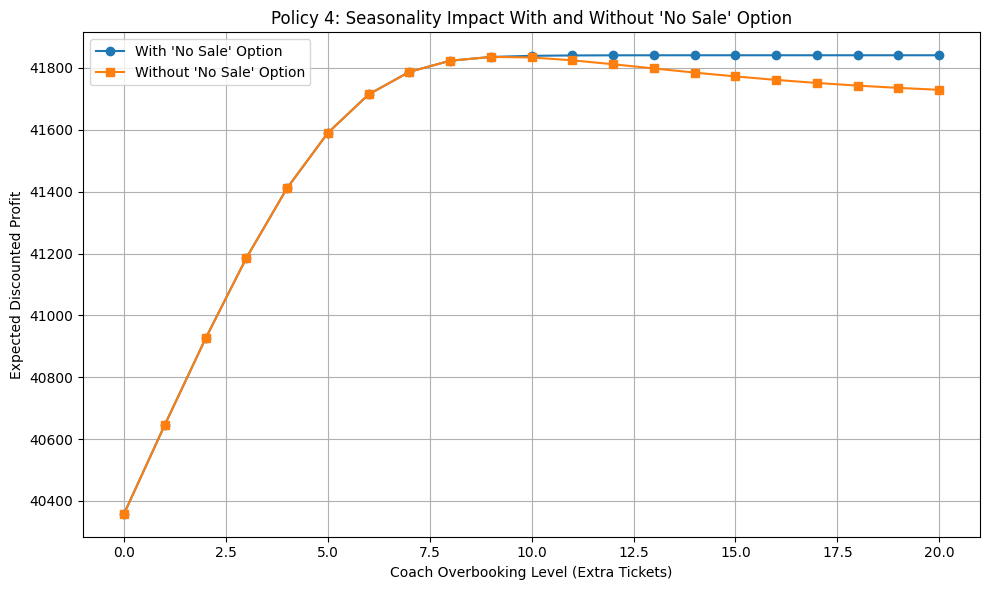

In [3]:
import math
from functools import lru_cache
import sys
import matplotlib.pyplot as plt

# Increase recursion limit to handle deep recursion in the dynamic programming algorithm
sys.setrecursionlimit(10000)

# Parameters
total_days = 365  # Total number of days for the booking period
# Daily discount factor computed from an annual rate of 17%
beta = 1 / (1 + 0.17 / total_days)

# Pricing decisions for first class represented as tuples: (price, probability)
fc_options = [(425, 0.08), (500, 0.04)]

# Pricing decisions for coach represented as tuples: (label, price, base probability, full first-class probability)
# "none" represents no sale option.
coach_options_all = [
    ("low", 300, 0.65, 0.68),
    ("high", 350, 0.30, 0.33),
    ("none", 0, 0.0, 0.0)
]

# Function to compute the binomial probability mass function (PMF)
# Calculates the probability of k successes in n independent trials with success probability p
def binom_pmf(n, k, p):
    return math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k))

# Compute terminal cost on flight day
# This function calculates the expected cost due to overbooking penalties and using free first-class seats
def compute_terminal_cost(s_c, s_f):
    expected_cost = 0.0
    # Loop over all possible numbers of coach passengers who show up
    for x in range(s_c + 1):
        prob_x = binom_pmf(s_c, x, 0.95)
        # Loop over all possible numbers of first-class passengers who show up
        for y in range(s_f + 1):
            prob_y = binom_pmf(s_f, y, 0.97)
            # Calculate number of available free first-class tickets
            free_fc = max(20 - y, 0)
            # Calculate number of coach passengers that overflow the allowed 100 seats
            overflow = max(x - 100, 0)
            # Cost calculation: use free first-class tickets first, then expensive re-accommodation if needed
            cost = min(overflow, free_fc) * 50 + max(overflow - free_fc, 0) * 425
            # Accumulate the weighted cost by the probabilities of the outcomes
            expected_cost += prob_x * prob_y * cost
    return expected_cost

# Solve the dynamic programming problem with seasonality effects
# allow_no_sale determines if the "no sale" option is allowed for coach seats
def solve_policy_with_seasonality(max_coach, allow_no_sale):
    # Determine available coach options based on whether "no sale" is allowed
    coach_options = coach_options_all if allow_no_sale else coach_options_all[:2]  # skip "none" if not allowed

    @lru_cache(maxsize=None)
    def V(d, s_c, s_f):
        # Base case: when no days are left, return negative terminal cost incurred on flight day
        if d == 0:
            return -compute_terminal_cost(s_c, s_f)

        # t represents the current day in the booking period (1-indexed)
        t = total_days - d + 1
        # multiplier introduces a seasonal adjustment to the probabilities
        multiplier = 0.75 + t / 730
        best_val = -float('inf')

        # Loop through each coach decision option
        for coach_label, coach_price, base_prob, full_fc_prob in coach_options:
            p_coach = 0.0
            # For options other than "none", compute the probability of a coach sale
            if coach_label != "none":
                p_coach = full_fc_prob if s_f == 20 else base_prob
                # Apply the seasonal multiplier to adjust the probability, capped at 1.0
                p_coach = min(p_coach * multiplier, 1.0)
                # If the number of coach seats sold is already at max_coach, no further coach sale is allowed
                if s_c >= max_coach:
                    p_coach = 0.0

            # Loop through each first-class option
            for fc_price, base_fc_prob in fc_options:
                # Adjust first-class sale probability with seasonality, capped at 1.0
                p_fc = min(base_fc_prob * multiplier, 1.0)
                # If first-class seats are already full (20 seats), no sale is allowed
                if s_f >= 20:
                    p_fc = 0.0

                expected_val = 0.0
                # No sale occurs for both coach and first-class
                expected_val += (1 - p_coach) * (1 - p_fc) * (0 + beta * V(d - 1, s_c, s_f))
                # Only a coach sale occurs
                expected_val += p_coach * (1 - p_fc) * (coach_price + beta * V(d - 1, min(s_c + 1, max_coach), s_f))
                # Only a first-class sale occurs
                expected_val += (1 - p_coach) * p_fc * (fc_price + beta * V(d - 1, s_c, min(s_f + 1, 20)))
                # Both sales occur simultaneously
                expected_val += p_coach * p_fc * (coach_price + fc_price +
                                                  beta * V(d - 1, min(s_c + 1, max_coach), min(s_f + 1, 20)))

                # Update best expected value if current decision yields higher profit
                best_val = max(best_val, expected_val)

        return best_val

    # Start the recursion with the total number of days and no seats sold
    return V(total_days, 0, 0)

# Evaluate both policies over a range of coach overbooking levels (from 0 to 20 extra tickets)
profits_with_no_sale = []
profits_without_no_sale = []
overbook_levels = list(range(0, 21))

# Loop over different extra overbooking levels to compute expected discounted profits for each policy
for extra in overbook_levels:
    max_coach = 100 + extra  # Maximum coach seats available after overbooking
    # Compute expected profit when "no sale" option is allowed
    p1 = solve_policy_with_seasonality(max_coach, allow_no_sale=True)
    # Compute expected profit when "no sale" option is not allowed
    p2 = solve_policy_with_seasonality(max_coach, allow_no_sale=False)
    profits_with_no_sale.append(p1)
    profits_without_no_sale.append(p2)
    # Print the results for each overbooking level
    print(f"Overbook {extra:2d} → Profit (with no sale): ${p1:,.2f}, Profit (no no-sale): ${p2:,.2f}")

# Identify the best overbooking level for each policy
best_idx_with = profits_with_no_sale.index(max(profits_with_no_sale))
best_idx_without = profits_without_no_sale.index(max(profits_without_no_sale))

print("\nBest Overbooking Level WITH 'no sale' option:")
print(f"  {overbook_levels[best_idx_with]} seats, Profit = ${profits_with_no_sale[best_idx_with]:,.2f}")
print("\nBest Overbooking Level WITHOUT 'no sale' option:")
print(f"  {overbook_levels[best_idx_without]} seats, Profit = ${profits_without_no_sale[best_idx_without]:,.2f}")

# Compare the two policies to determine which performs better
if profits_with_no_sale[best_idx_with] > profits_without_no_sale[best_idx_without]:
    best_ob2 = best_idx_with
    allow_no_sale = True
    print(f"\n→ 'No sale' policy performs BETTER by ${profits_with_no_sale[best_idx_with] - profits_without_no_sale[best_idx_without]:,.2f}")
else:
    best_ob2 = best_idx_without
    allow_no_sale = False
    print(f"\n→ Fixed overbooking policy performs BETTER by ${profits_without_no_sale[best_idx_without] - profits_with_no_sale[best_idx_with]:,.2f}")

# Plot the expected discounted profit versus coach overbooking level for both policies
plt.figure(figsize=(10, 6))
plt.plot(overbook_levels, profits_with_no_sale, label="With 'No Sale' Option", marker='o')
plt.plot(overbook_levels, profits_without_no_sale, label="Without 'No Sale' Option", marker='s')
plt.xlabel("Coach Overbooking Level (Extra Tickets)")
plt.ylabel("Expected Discounted Profit")
plt.title("Policy 4: Seasonality Impact With and Without 'No Sale' Option")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Question 5

### Policy 2 Simulation

 Starting forward simulation for Policy 2...
 Parameters: max_coach = 120, allow_no_sale = True, num_runs = 10000

  ▶️ Simulation 1 of 10000
  ▶️ Simulation 1000 of 10000
  ▶️ Simulation 2000 of 10000
  ▶️ Simulation 3000 of 10000
  ▶️ Simulation 4000 of 10000
  ▶️ Simulation 5000 of 10000
  ▶️ Simulation 6000 of 10000
  ▶️ Simulation 7000 of 10000
  ▶️ Simulation 8000 of 10000
  ▶️ Simulation 9000 of 10000
  ▶️ Simulation 10000 of 10000

 Forward Simulation Results for Policy 2:
  Avg Profit: $41677.73
  Std Dev Profit: $1002.47
  Avg Overbooking Cost: $1014.47
  Coach Overbooking Frequency: 82.58%
  Avg Passengers Kicked Off: 2.29


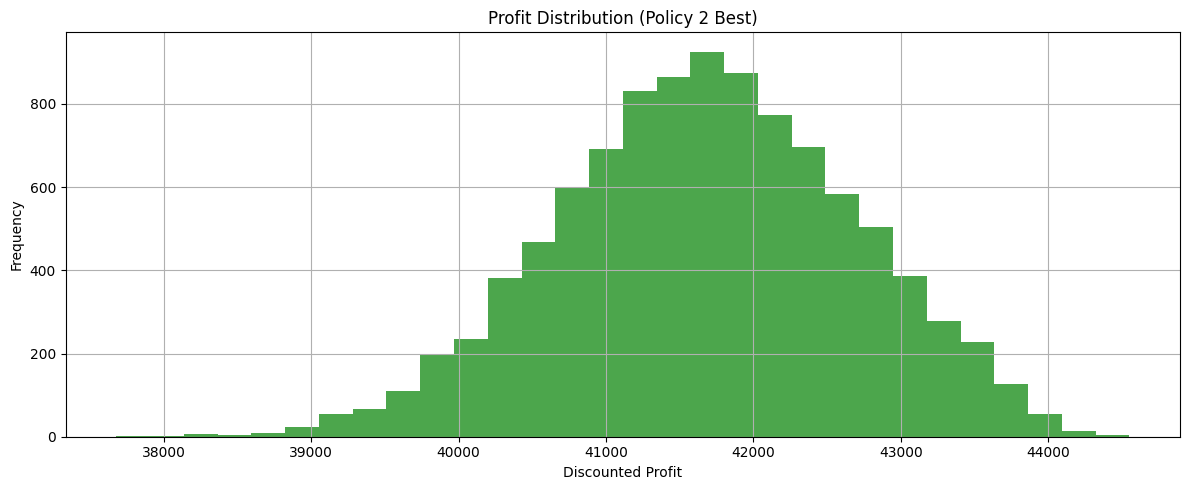

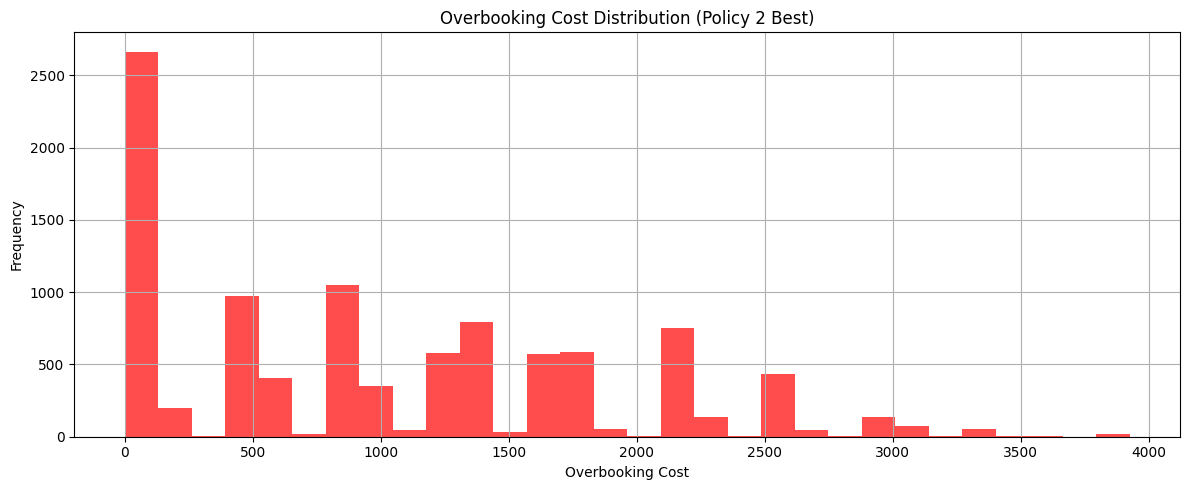

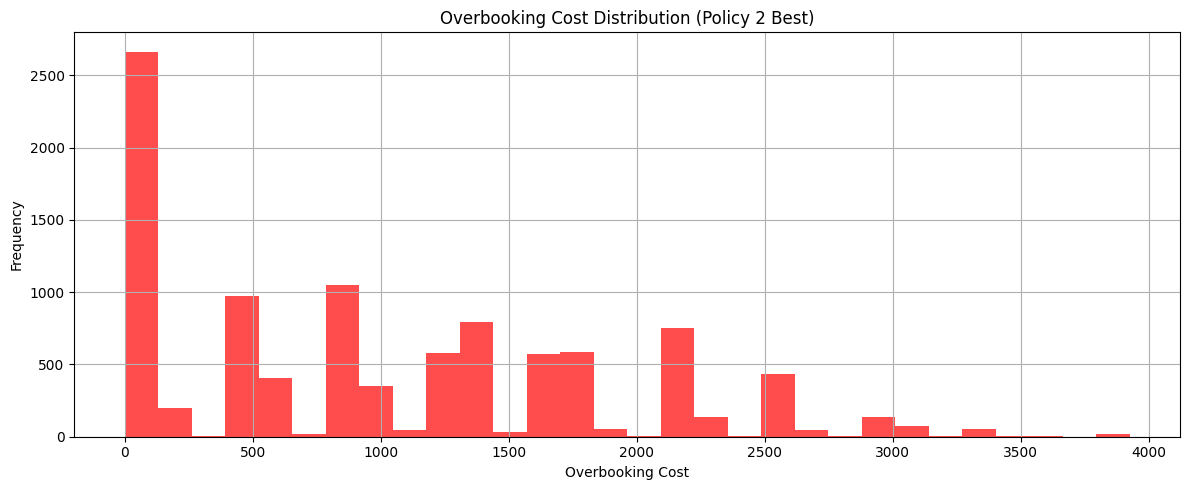

In [4]:
# Policy 2 simulation

import math
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Parameters ---
total_days = 365  # Total number of days for the booking period
# Daily discount factor computed from an annual 17% rate
beta = 1 / (1 + 0.17 / total_days)
show_prob_coach = 0.95  # Probability a coach passenger shows up
show_prob_fc = 0.97     # Probability a first-class passenger shows up
max_fc = 20             # Maximum number of first-class seats

# Use previously computed best overbooking level and policy indicator
best_ob2 = best_ob2
allow_no_sale = allow_no_sale
max_coach = 100 + best_ob2  # Maximum number of coach seats including overbooking

# Define first-class pricing options as tuples: (price, probability)
fc_options = [(425, 0.08), (500, 0.04)]
# Define coach pricing options as tuples: (label, price, base probability, full first-class probability)
coach_options_all = [("low", 300, 0.65, 0.68),
                     ("high", 350, 0.30, 0.33),
                     ("none", 0, 0.0, 0.0)]

# --- Binomial PMF ---
# Function to compute the probability of exactly k successes in n independent trials with probability p
def binom_pmf(n, k, p):
    return math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k))

# --- Terminal Overbooking Cost ---
# Function to compute the expected overbooking cost on flight day given sold seats for coach (s_c) and first-class (s_f)
def compute_terminal_cost(s_c, s_f):
    expected_cost = 0.0
    # Loop over possible number of coach passengers who show up
    for x in range(s_c + 1):
        prob_x = binom_pmf(s_c, x, show_prob_coach)
        # Loop over possible number of first-class passengers who show up
        for y in range(s_f + 1):
            prob_y = binom_pmf(s_f, y, show_prob_fc)
            # Calculate free first-class seats available to cover coach overflow
            free_fc = max(max_fc - y, 0)
            # Calculate number of coach passengers that overflow the allowed 100 seats
            overflow = max(x - 100, 0)
            # Calculate cost: use free first-class tickets first ($50), then expensive re-accommodation ($425)
            cost = min(overflow, free_fc) * 50 + max(overflow - free_fc, 0) * 425
            # Accumulate the weighted cost based on the probability of each outcome
            expected_cost += prob_x * prob_y * cost
    return expected_cost

# --- Step 1: Solve DP ---
# Dictionaries to store the computed optimal value and corresponding policy decisions for each state
policy2_dict = {}
V_dict = {}

def solve_policy2_simulation():
    # Select available coach options based on whether the "no sale" option is allowed
    coach_options = coach_options_all if allow_no_sale else coach_options_all[:2]

    # Loop over all possible states in the dynamic programming formulation:
    # d: number of days remaining, s_c: coach seats sold, s_f: first-class seats sold
    for d in range(0, total_days + 1):
        for s_c in range(0, max_coach + 1):
            for s_f in range(0, max_fc + 1):
                # Base case: when no days remain, the value is the negative terminal cost
                if d == 0:
                    V_dict[(d, s_c, s_f)] = -compute_terminal_cost(s_c, s_f)
                    continue

                # Calculate the current day index (1-indexed)
                t = total_days - d + 1
                # Apply a seasonal multiplier that adjusts probabilities over the booking period
                multiplier = 0.75 + t / 730
                best_val = -float('inf')
                best_action = None

                # Iterate over each coach option in the decision set
                for label, price_c, base_p, full_fc_p in coach_options:
                    # If maximum coach capacity is reached, set coach sale probability to 0
                    if s_c >= max_coach:
                        p_coach = 0
                    else:
                        # Select probability based on whether first-class is full
                        p_coach = full_fc_p if s_f == 20 else base_p
                        # Adjust probability with seasonal multiplier, capped at 1.0
                        p_coach = min(p_coach * multiplier, 1.0)

                    # Iterate over each first-class option
                    for price_f, base_p_fc in fc_options:
                        # Adjust first-class sale probability with seasonal multiplier, capped at 1.0
                        p_fc = 0 if s_f >= max_fc else min(base_p_fc * multiplier, 1.0)

                        val = 0
                        # Compute expected value if no sale occurs
                        val += (1 - p_coach) * (1 - p_fc) * (0 + beta * V_dict[(d - 1, s_c, s_f)])
                        # Compute expected value if only a coach sale occurs
                        val += p_coach * (1 - p_fc) * (price_c + beta * V_dict[(d - 1, min(s_c + 1, max_coach), s_f)])
                        # Compute expected value if only a first-class sale occurs
                        val += (1 - p_coach) * p_fc * (price_f + beta * V_dict[(d - 1, s_c, min(s_f + 1, max_fc))])
                        # Compute expected value if both sales occur
                        val += p_coach * p_fc * (price_c + price_f +
                                                 beta * V_dict[(d - 1, min(s_c + 1, max_coach), min(s_f + 1, max_fc))])

                        # Update best value and best action if current decision yields a higher expected value
                        if val > best_val:
                            best_val = val
                            best_action = (price_c, price_f, p_coach, p_fc)

                # Store the computed optimal value and the corresponding best action for state (d, s_c, s_f)
                V_dict[(d, s_c, s_f)] = best_val
                policy2_dict[(d, s_c, s_f)] = best_action

# --- Step 2: Simulate Forward ---
# Function to simulate the forward progression of the booking process using the computed policy
def simulate_forward_policy2(policy_dict, max_coach, num_runs=10000):
    print(f" Starting forward simulation for Policy 2...")
    print(f" Parameters: max_coach = {max_coach}, allow_no_sale = {allow_no_sale}, num_runs = {num_runs}\n")

    profits, costs, overbook_freq, kicked = [], [], 0, 0
    # Run multiple simulation runs to estimate performance metrics
    for run in range(1, num_runs + 1):
        # Print progress periodically
        if num_runs <= 20 or run % (num_runs // 10) == 0 or run == 1:
            print(f"  ▶️ Simulation {run} of {num_runs}")

        s_c = s_f = 0  # Initialize state variables: seats sold for coach and first-class
        revenue = 0.0  # Initialize accumulated revenue
        # Simulate the booking process backwards from the last day to the first
        for d in reversed(range(1, total_days + 1)):
            # Retrieve the policy decision for the current state
            coach_price, fc_price, p_c, p_f = policy_dict.get((d, s_c, s_f), (0, 0, 0, 0))
            r = random.random()  # Generate a random number to decide the sale outcome
            # Determine thresholds for each sale event (no sale, coach only, FC only, both)
            thresholds = [(1 - p_c) * (1 - p_f),
                          (1 - p_c) * (1 - p_f) + p_c * (1 - p_f),
                          (1 - p_c) * (1 - p_f) + p_c * (1 - p_f) + (1 - p_c) * p_f]
            if r < thresholds[0]:
                # No sale: state remains unchanged
                pass
            elif r < thresholds[1]:
                # Only coach sale occurs: update revenue and increment coach sale count
                revenue += coach_price * (beta ** (365 - d))
                s_c = min(s_c + 1, max_coach)
            elif r < thresholds[2]:
                # Only first-class sale occurs: update revenue and increment first-class sale count
                revenue += fc_price * (beta ** (365 - d))
                s_f = min(s_f + 1, max_fc)
            else:
                # Both sales occur: update revenue and increment both sale counts
                revenue += (coach_price + fc_price) * (beta ** (365 - d))
                s_c = min(s_c + 1, max_coach)
                s_f = min(s_f + 1, max_fc)

        # Simulate the flight day outcomes using binomial distributions for no-shows
        x = np.random.binomial(s_c, show_prob_coach)
        y = np.random.binomial(s_f, show_prob_fc)
        # Calculate free first-class seats available to accommodate overflow from coach
        free_fc = max_fc - y
        # Calculate overflow of coach passengers beyond 100 allowed seats
        overflow = max(x - 100, 0)
        # Compute cost incurred due to overbooking penalties
        cost = min(overflow, free_fc) * 50 + max(overflow - free_fc, 0) * 425
        profit = revenue - cost  # Net profit for the run
        # Track frequency of overbooking events and number of passengers kicked off
        if overflow > 0:
            overbook_freq += 1
            kicked += max(overflow - free_fc, 0)
        profits.append(profit)
        costs.append(cost)

    # Return simulation statistics: profit and cost distributions, averages, and overbooking metrics
    return {
        "profits": profits,
        "costs": costs,
        "avg_profit": np.mean(profits),
        "std_profit": np.std(profits),
        "avg_cost": np.mean(costs),
        "overbook_freq": overbook_freq / num_runs,
        "avg_kicked": kicked / num_runs
    }

# === Run and Display ===
# Compute the optimal policy using dynamic programming simulation
solve_policy2_simulation()
# Run forward simulation using the computed policy
stats2 = simulate_forward_policy2(policy2_dict, max_coach, num_runs=10000)

# Display simulation results
print("\n Forward Simulation Results for Policy 2:")
print(f"  Avg Profit: ${stats2['avg_profit']:.2f}")
print(f"  Std Dev Profit: ${stats2['std_profit']:.2f}")
print(f"  Avg Overbooking Cost: ${stats2['avg_cost']:.2f}")
print(f"  Coach Overbooking Frequency: {stats2['overbook_freq']:.2%}")
print(f"  Avg Passengers Kicked Off: {stats2['avg_kicked']:.2f}")

# === Plot ===
# Plot histogram of discounted profits from the simulation
plt.figure(figsize=(12, 5))
plt.hist(stats2["profits"], bins=30, alpha=0.7, color='green')
plt.xlabel("Discounted Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution (Policy 2 Best)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histogram of overbooking costs from the simulation
plt.figure(figsize=(12, 5))
plt.hist(stats2["costs"], bins=30, alpha=0.7, color='red')
plt.xlabel("Overbooking Cost")
plt.ylabel("Frequency")
plt.title("Overbooking Cost Distribution (Policy 2 Best)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot another histogram of overbooking costs
plt.figure(figsize=(12, 5))
plt.hist(stats2["costs"], bins=30, alpha=0.7, color='red')
plt.xlabel("Overbooking Cost")
plt.ylabel("Frequency")
plt.title("Overbooking Cost Distribution (Policy 2 Best)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Policy 1 Simulation

 Starting forward simulation for Policy 1...
 Parameters: max_coach = 109, allow_no_sale = False, num_runs = 10000

  ▶️ Simulation 1 of 10000
  ▶️ Simulation 1000 of 10000
  ▶️ Simulation 2000 of 10000
  ▶️ Simulation 3000 of 10000
  ▶️ Simulation 4000 of 10000
  ▶️ Simulation 5000 of 10000
  ▶️ Simulation 6000 of 10000
  ▶️ Simulation 7000 of 10000
  ▶️ Simulation 8000 of 10000
  ▶️ Simulation 9000 of 10000
  ▶️ Simulation 10000 of 10000

 Forward Simulation Results for Policy 1:
  Avg Profit: $41969.34
  Std Dev Profit: $994.19
  Avg Overbooking Cost: $992.62
  Coach Overbooking Frequency: 81.94%
  Avg Passengers Kicked Off: 2.25


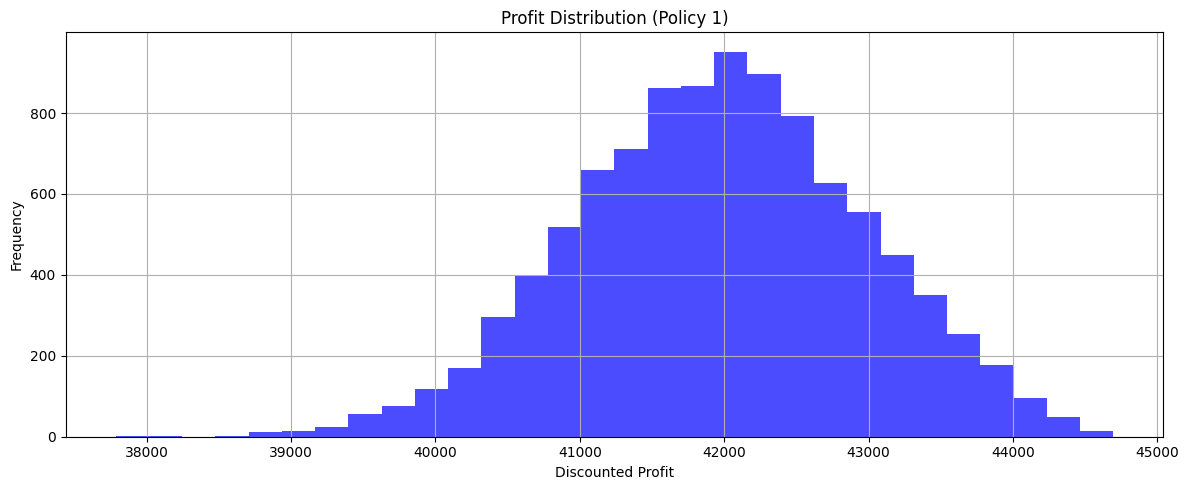

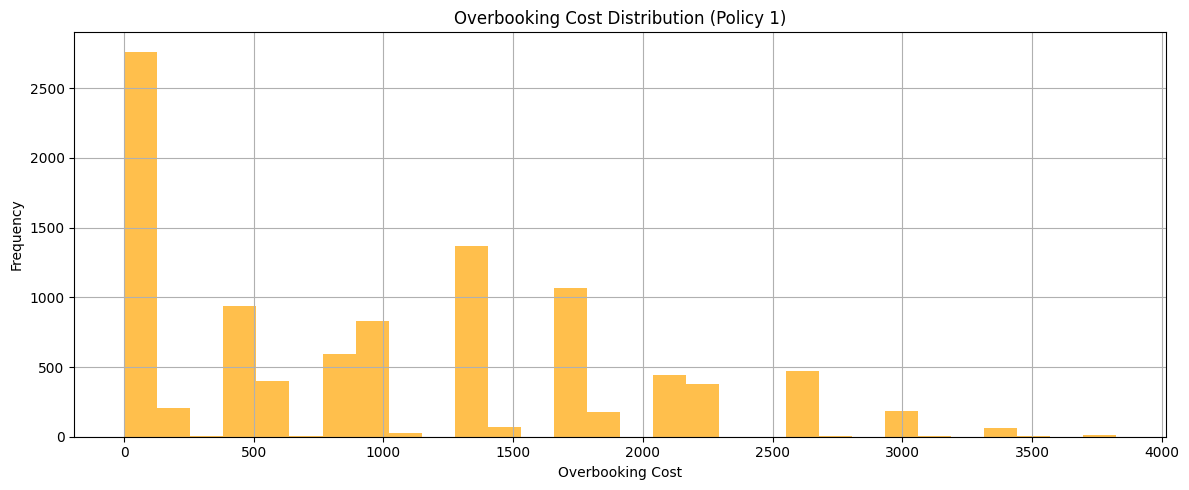

In [8]:
# Policy 1 Simulation
import math
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Parameters ---
total_days = 365  # Total number of days in the booking period
# Daily discount factor based on an annual 17% rate
beta = 1 / (1 + 0.17 / total_days)
show_prob_coach = 0.95  # Probability that a coach passenger shows up
show_prob_fc = 0.97     # Probability that a first-class passenger shows up
max_fc = 20             # Maximum number of first-class seats

best_ob1 = best_ob1    # Best overbooking level for Policy 1 (assumed to be defined externally)
allow_no_sale = False  # Policy 1 does not allow the 'no sale' option
max_coach = 100 + best_ob1  # Maximum number of coach seats including overbooking

# Define first-class pricing options as tuples: (price, probability)
fc_options = [(425, 0.08), (500, 0.04)]
# Define coach pricing options as tuples: (label, price, base probability, full first-class probability)
# Only include "low" and "high" options since Policy 1 ignores 'none'
coach_options_all = [("low", 300, 0.65, 0.68),
                     ("high", 350, 0.30, 0.33)]  # will ignore 'none' for policy 1

# --- Binomial PMF ---
# Function to compute the binomial probability mass function:
# Calculates the probability of exactly k successes in n trials with success probability p.
def binom_pmf(n, k, p):
    return math.comb(n, k) * (p ** k) * ((1 - p) ** (n - k))

# --- Terminal Overbooking Cost ---
# Function to compute the expected overbooking cost on flight day
# given the number of coach (s_c) and first-class (s_f) seats sold.
def compute_terminal_cost(s_c, s_f):
    expected_cost = 0.0
    # Loop over all possible numbers of coach passengers who show up.
    for x in range(s_c + 1):
        prob_x = binom_pmf(s_c, x, show_prob_coach)
        # Loop over all possible numbers of first-class passengers who show up.
        for y in range(s_f + 1):
            prob_y = binom_pmf(s_f, y, show_prob_fc)
            # Compute the number of free first-class seats available to cover coach overflow.
            free_fc = max(max_fc - y, 0)
            # Compute the number of coach passengers exceeding the allowed 100 seats.
            overflow = max(x - 100, 0)
            # Calculate cost: first use free first-class seats at $50, then $425 for additional re-accommodation.
            cost = min(overflow, free_fc) * 50 + max(overflow - free_fc, 0) * 425
            # Accumulate the expected cost weighted by the probability of this outcome.
            expected_cost += prob_x * prob_y * cost
    return expected_cost

# --- Step 1: Solve DP ---
# Dictionaries to store the optimal value function and policy for each state.
policy1_dict = {}
V_dict = {}

def solve_policy1_simulation():
    # Only use the coach options that are available for Policy 1 (i.e., 'low' and 'high').
    coach_options = coach_options_all[:2]  # only low and high, no 'none'

    # Loop over the state space: d (days remaining), s_c (coach seats sold), s_f (first-class seats sold)
    for d in range(0, total_days + 1):
        for s_c in range(0, max_coach + 1):
            for s_f in range(0, max_fc + 1):
                # Base case: when no days remain, set the value function to the negative terminal cost.
                if d == 0:
                    V_dict[(d, s_c, s_f)] = -compute_terminal_cost(s_c, s_f)
                    continue

                multiplier = 1.0  # No seasonality adjustment for Policy 1
                best_val = -float('inf')
                best_action = None

                # Evaluate each coach pricing option.
                for label, price_c, base_p, full_fc_p in coach_options:
                    # If maximum coach capacity is reached, set the coach sale probability to 0.
                    if s_c >= max_coach:
                        p_coach = 0
                    else:
                        # Choose the probability based on whether first-class is full.
                        p_coach = full_fc_p if s_f == 20 else base_p
                        p_coach = min(p_coach * multiplier, 1.0)

                    # Evaluate each first-class pricing option.
                    for price_f, base_p_fc in fc_options:
                        # Set first-class sale probability, with multiplier and capacity check.
                        p_fc = 0 if s_f >= max_fc else min(base_p_fc * multiplier, 1.0)

                        val = 0
                        # Expected value if no sale occurs.
                        val += (1 - p_coach) * (1 - p_fc) * (beta * V_dict[(d - 1, s_c, s_f)])
                        # Expected value if only a coach sale occurs.
                        val += p_coach * (1 - p_fc) * (price_c + beta * V_dict[(d - 1, min(s_c + 1, max_coach), s_f)])
                        # Expected value if only a first-class sale occurs.
                        val += (1 - p_coach) * p_fc * (price_f + beta * V_dict[(d - 1, s_c, min(s_f + 1, max_fc))])
                        # Expected value if both sales occur.
                        val += p_coach * p_fc * (price_c + price_f +
                                                 beta * V_dict[(d - 1, min(s_c + 1, max_coach), min(s_f + 1, max_fc))])

                        # Update the best value and corresponding action if the current one is better.
                        if val > best_val:
                            best_val = val
                            best_action = (price_c, price_f, p_coach, p_fc)

                # Store the computed optimal value and best action for the current state.
                V_dict[(d, s_c, s_f)] = best_val
                policy1_dict[(d, s_c, s_f)] = best_action

# --- Step 2: Simulate Forward ---
# Function to simulate the booking process forward using the computed policy.
def simulate_forward_policy1(policy_dict, max_coach, num_runs=10000):
    print(f" Starting forward simulation for Policy 1...")
    print(f" Parameters: max_coach = {max_coach}, allow_no_sale = {allow_no_sale}, num_runs = {num_runs}\n")

    profits, costs, overbook_freq, kicked = [], [], 0, 0
    # Run multiple simulations to assess the performance of the policy.
    for run in range(1, num_runs + 1):
        if num_runs <= 20 or run % (num_runs // 10) == 0 or run == 1:
            print(f"  ▶️ Simulation {run} of {num_runs}")

        s_c = s_f = 0  # Initialize sold seats for coach and first-class to zero.
        revenue = 0.0  # Initialize accumulated revenue.
        # Simulate the booking process day-by-day in reverse order (from day 365 to day 1).
        for d in reversed(range(1, total_days + 1)):
            # Retrieve the optimal decision for the current state.
            coach_price, fc_price, p_c, p_f = policy_dict.get((d, s_c, s_f), (0, 0, 0, 0))
            r = random.random()  # Random number to determine which sale occurs.
            # Define thresholds for no sale, coach only, FC only, and both sale events.
            thresholds = [(1 - p_c) * (1 - p_f),
                          (1 - p_c) * (1 - p_f) + p_c * (1 - p_f),
                          (1 - p_c) * (1 - p_f) + p_c * (1 - p_f) + (1 - p_c) * p_f]
            if r < thresholds[0]:
                # No sale occurs; state remains unchanged.
                pass
            elif r < thresholds[1]:
                # Only a coach sale occurs; update revenue and increment coach sales.
                revenue += coach_price * (beta ** (365 - d))
                s_c = min(s_c + 1, max_coach)
            elif r < thresholds[2]:
                # Only a first-class sale occurs; update revenue and increment first-class sales.
                revenue += fc_price * (beta ** (365 - d))
                s_f = min(s_f + 1, max_fc)
            else:
                # Both sales occur; update revenue and increment both sale counts.
                revenue += (coach_price + fc_price) * (beta ** (365 - d))
                s_c = min(s_c + 1, max_coach)
                s_f = min(s_f + 1, max_fc)

        # On flight day, simulate the actual number of passengers showing up using a binomial distribution.
        x = np.random.binomial(s_c, show_prob_coach)
        y = np.random.binomial(s_f, show_prob_fc)
        # Determine available free first-class seats and coach overflow.
        free_fc = max_fc - y
        overflow = max(x - 100, 0)
        # Calculate the overbooking cost.
        cost = min(overflow, free_fc) * 50 + max(overflow - free_fc, 0) * 425
        profit = revenue - cost  # Compute net profit for this simulation run.
        # Track overbooking frequency and the number of passengers who were denied boarding.
        if overflow > 0:
            overbook_freq += 1
            kicked += max(overflow - free_fc, 0)
        profits.append(profit)
        costs.append(cost)

    # Return a dictionary containing simulation statistics.
    return {
        "profits": profits,
        "costs": costs,
        "avg_profit": np.mean(profits),
        "std_profit": np.std(profits),
        "avg_cost": np.mean(costs),
        "overbook_freq": overbook_freq / num_runs,
        "avg_kicked": kicked / num_runs
    }

# === Run and Display ===
solve_policy1_simulation()  # Solve the dynamic programming problem for Policy 1
stats1 = simulate_forward_policy1(policy1_dict, max_coach, num_runs=10000)  # Run forward simulation

# Print simulation results for Policy 1.
print("\n Forward Simulation Results for Policy 1:")
print(f"  Avg Profit: ${stats1['avg_profit']:.2f}")
print(f"  Std Dev Profit: ${stats1['std_profit']:.2f}")
print(f"  Avg Overbooking Cost: ${stats1['avg_cost']:.2f}")
print(f"  Coach Overbooking Frequency: {stats1['overbook_freq']:.2%}")
print(f"  Avg Passengers Kicked Off: {stats1['avg_kicked']:.2f}")

# === Plot ===
# Plot histogram of discounted profits.
plt.figure(figsize=(12, 5))
plt.hist(stats1["profits"], bins=30, alpha=0.7, color='blue')
plt.xlabel("Discounted Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution (Policy 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histogram of overbooking costs.
plt.figure(figsize=(12, 5))
plt.hist(stats1["costs"], bins=30, alpha=0.7, color='orange')
plt.xlabel("Overbooking Cost")
plt.ylabel("Frequency")
plt.title("Overbooking Cost Distribution (Policy 1)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Policy comparison

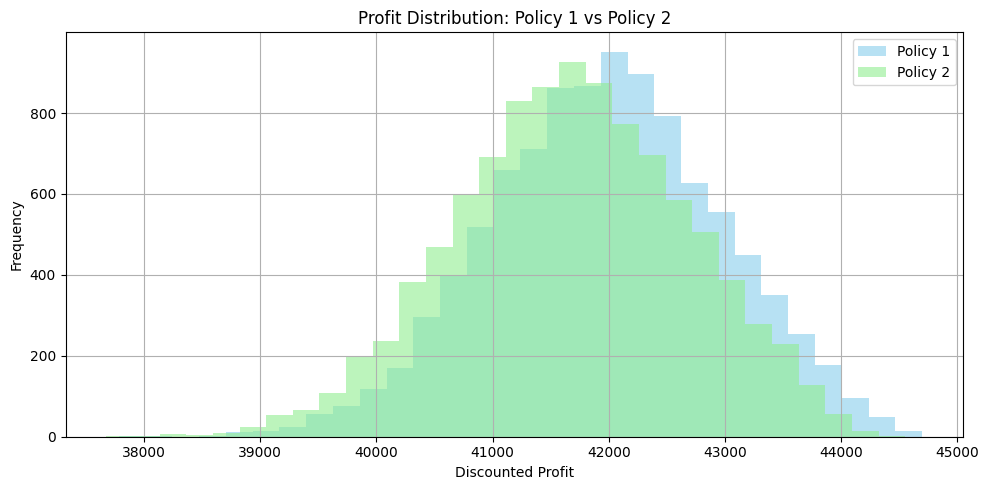

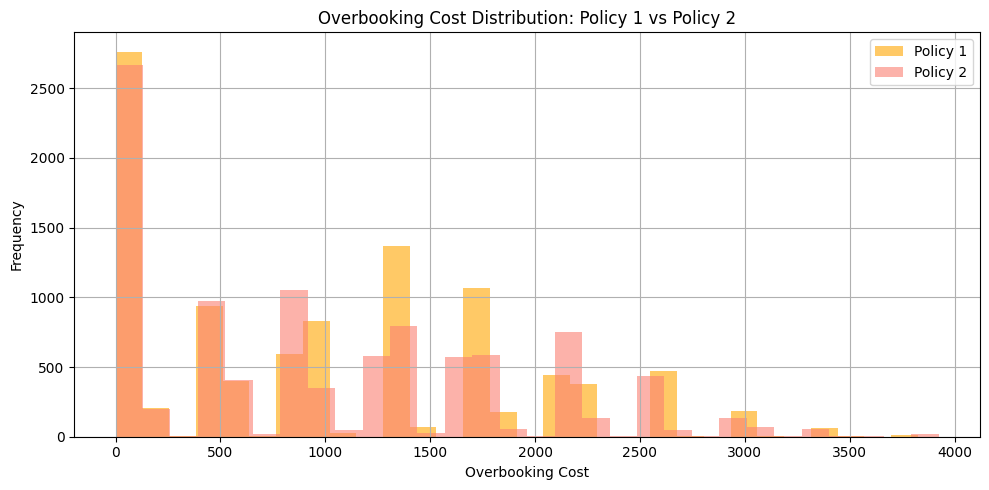

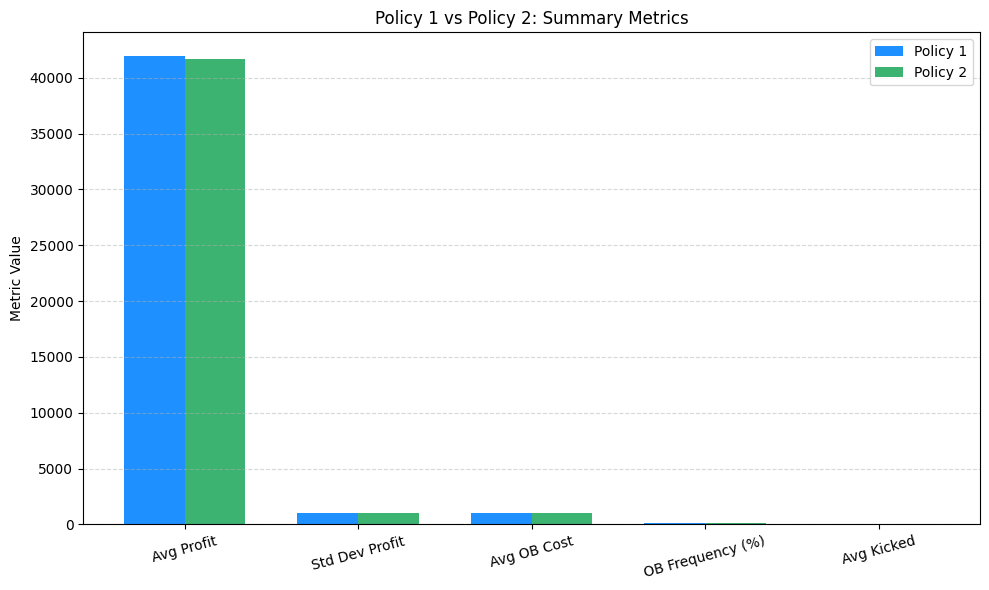

<ipython-input-9-0a204f01c89a>:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([stats_policy1["profits"], stats_policy2["profits"]],


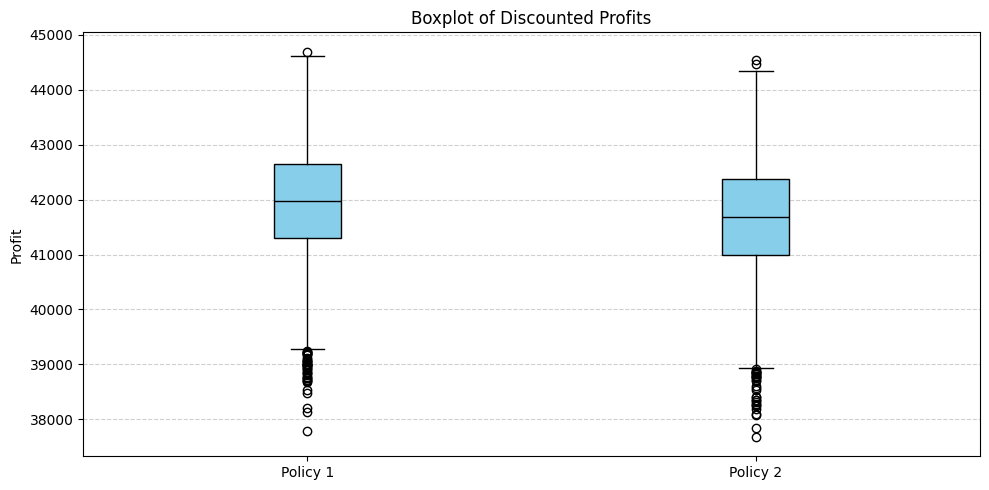

<ipython-input-9-0a204f01c89a>:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([stats_policy1["costs"], stats_policy2["costs"]],


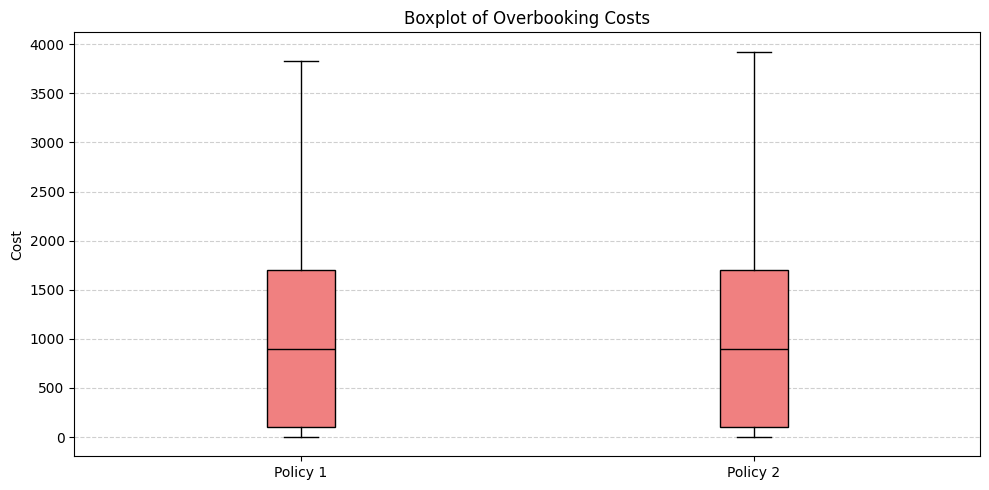

In [9]:
# === POLICY COMPARISON VISUALIZATION BLOCK ===
# Make sure `stats` (for Policy 1) and `stats_policy2` are defined

import matplotlib.pyplot as plt
import numpy as np

# Rename if needed
stats_policy1 = stats1
stats_policy2 = stats2

# --- 1. Profit Distribution ---
plt.figure(figsize=(10, 5))
plt.hist(stats_policy1["profits"], bins=30, alpha=0.6, label="Policy 1", color='skyblue')
plt.hist(stats_policy2["profits"], bins=30, alpha=0.6, label="Policy 2", color='lightgreen')
plt.xlabel("Discounted Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution: Policy 1 vs Policy 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. Overbooking Cost Distribution ---
plt.figure(figsize=(10, 5))
plt.hist(stats_policy1["costs"], bins=30, alpha=0.6, label="Policy 1", color='orange')
plt.hist(stats_policy2["costs"], bins=30, alpha=0.6, label="Policy 2", color='salmon')
plt.xlabel("Overbooking Cost")
plt.ylabel("Frequency")
plt.title("Overbooking Cost Distribution: Policy 1 vs Policy 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Summary Metric Comparison (Bar Plot) ---
labels = ['Avg Profit', 'Std Dev Profit', 'Avg OB Cost', 'OB Frequency (%)', 'Avg Kicked']

policy1_vals = [
    stats_policy1['avg_profit'],
    stats_policy1['std_profit'],
    stats_policy1['avg_cost'],
    100 * stats_policy1['overbook_freq'],  # in %
    stats_policy1['avg_kicked']
]

policy2_vals = [
    stats_policy2['avg_profit'],
    stats_policy2['std_profit'],
    stats_policy2['avg_cost'],
    100 * stats_policy2['overbook_freq'],  # in %
    stats_policy2['avg_kicked']
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, policy1_vals, width, label='Policy 1', color='dodgerblue')
plt.bar(x + width/2, policy2_vals, width, label='Policy 2', color='mediumseagreen')
plt.xticks(x, labels, rotation=15)
plt.ylabel("Metric Value")
plt.title("Policy 1 vs Policy 2: Summary Metrics")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 4. Profit & Cost Boxplots ---
plt.figure(figsize=(10, 5))
plt.boxplot([stats_policy1["profits"], stats_policy2["profits"]],
            labels=["Policy 1", "Policy 2"],
            patch_artist=True,
            boxprops=dict(facecolor='skyblue'),
            medianprops=dict(color='black'))
plt.title("Boxplot of Discounted Profits")
plt.ylabel("Profit")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.boxplot([stats_policy1["costs"], stats_policy2["costs"]],
            labels=["Policy 1", "Policy 2"],
            patch_artist=True,
            boxprops=dict(facecolor='lightcoral'),
            medianprops=dict(color='black'))
plt.title("Boxplot of Overbooking Costs")
plt.ylabel("Cost")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


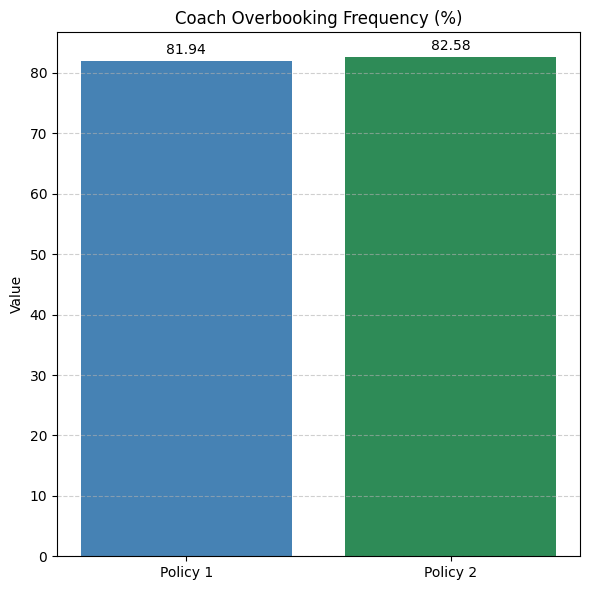

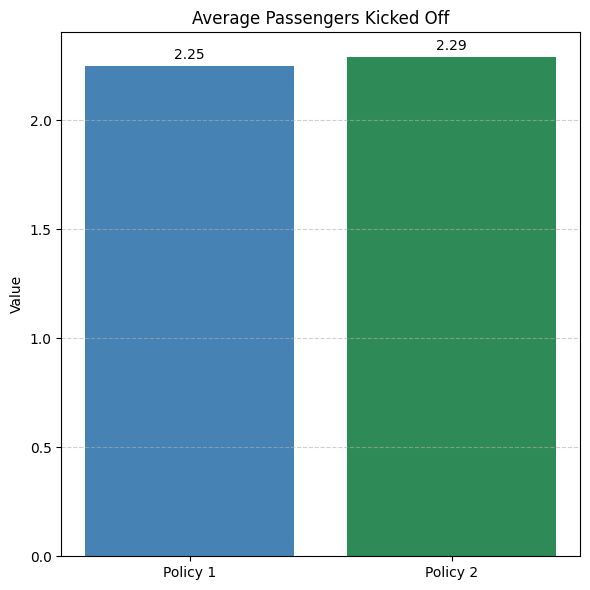

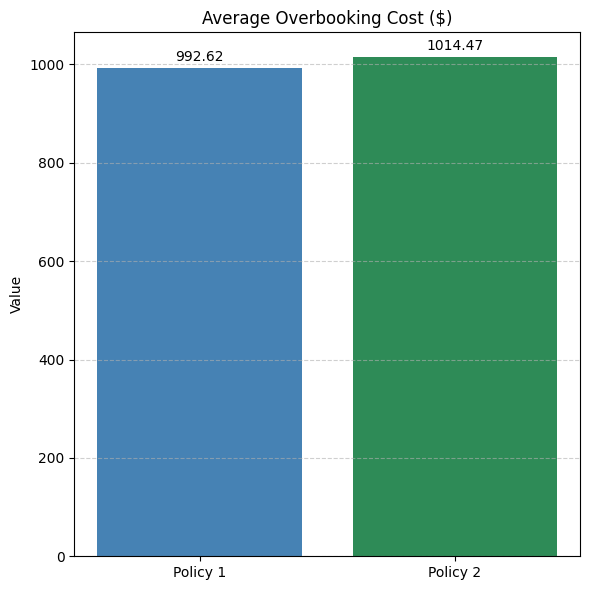

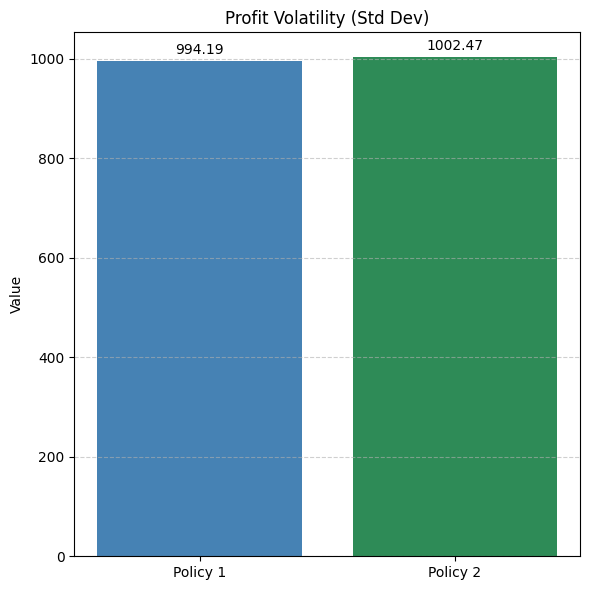

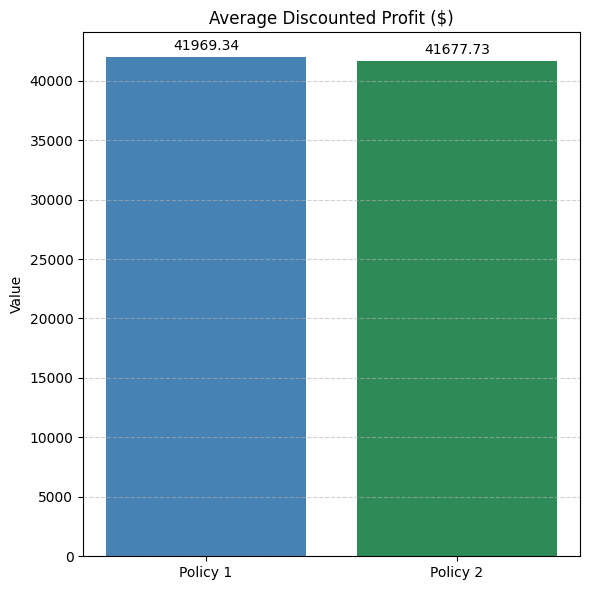

In [11]:
# === SEPARATE METRIC COMPARISON PLOTS: POLICY 1 vs POLICY 2 ===
import matplotlib.pyplot as plt
import numpy as np

# Assuming:
# stats_policy1 = simulate_forward_policy1(...)
# stats_policy2 = simulate_forward_policy2(...)

# Define metric names and values
metrics = [
    ("Coach Overbooking Frequency (%)", stats_policy1['overbook_freq'] * 100, stats_policy2['overbook_freq'] * 100),
    ("Average Passengers Kicked Off", stats_policy1['avg_kicked'], stats_policy2['avg_kicked']),
    ("Average Overbooking Cost ($)", stats_policy1['avg_cost'], stats_policy2['avg_cost']),
    ("Profit Volatility (Std Dev)", stats_policy1['std_profit'], stats_policy2['std_profit']),
    ("Average Discounted Profit ($)", stats_policy1['avg_profit'], stats_policy2['avg_profit'])
]

# Create separate bar charts for each metric
for title, val1, val2 in metrics:
    plt.figure(figsize=(6, 6))
    bars = plt.bar(['Policy 1', 'Policy 2'], [val1, val2], color=['steelblue', 'seagreen'])
    plt.title(title)
    plt.ylabel("Value")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


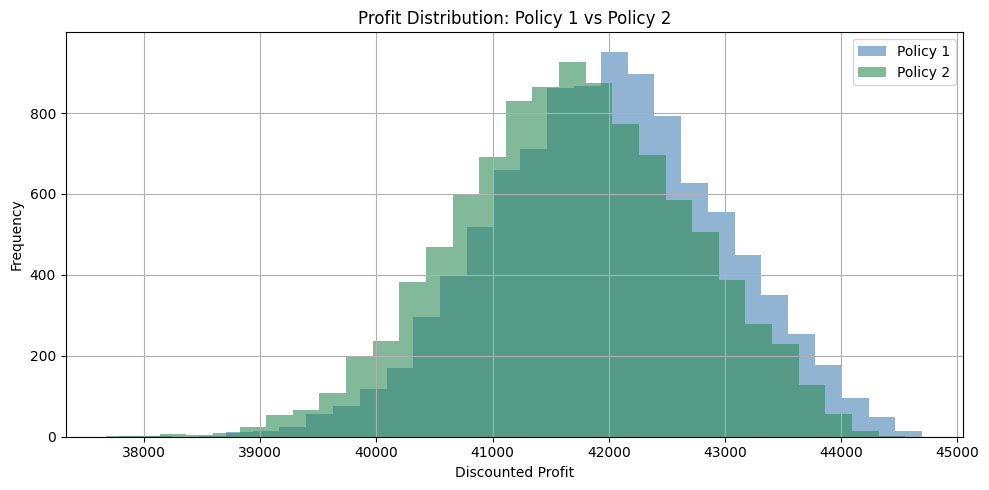

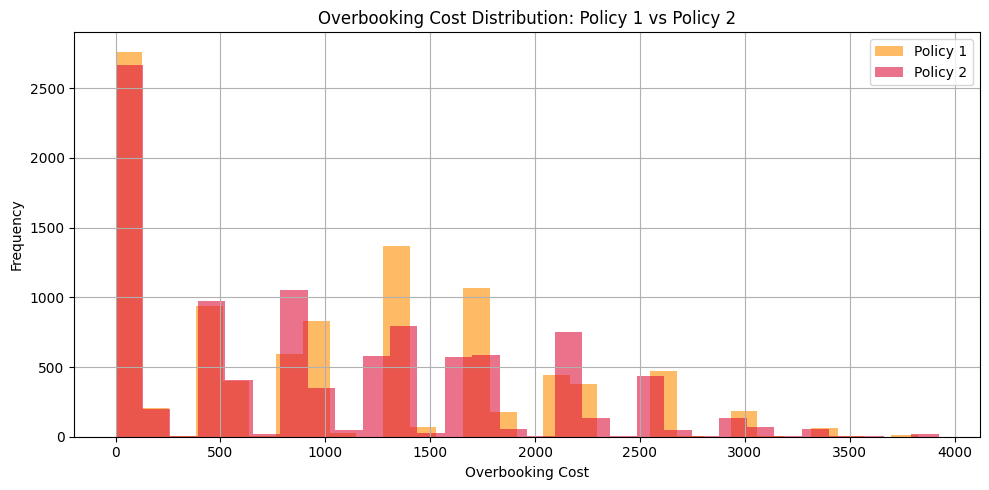

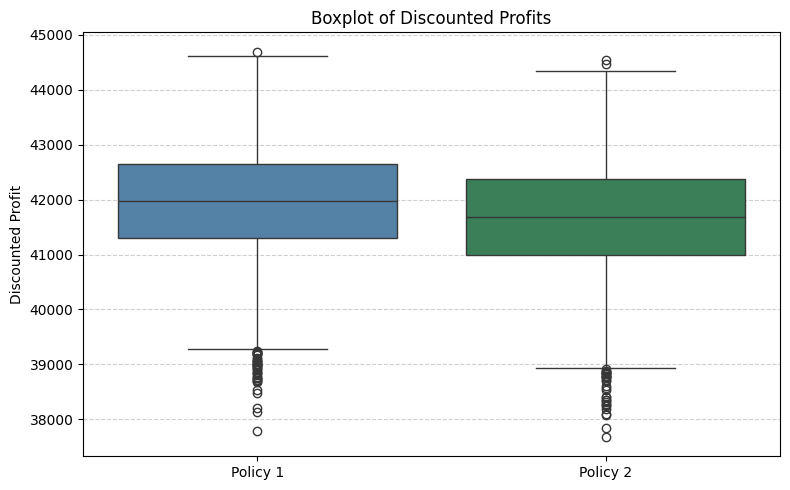

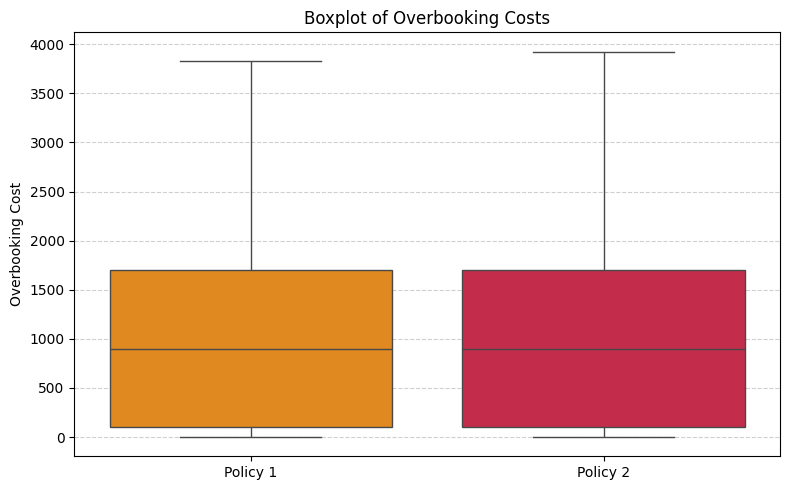

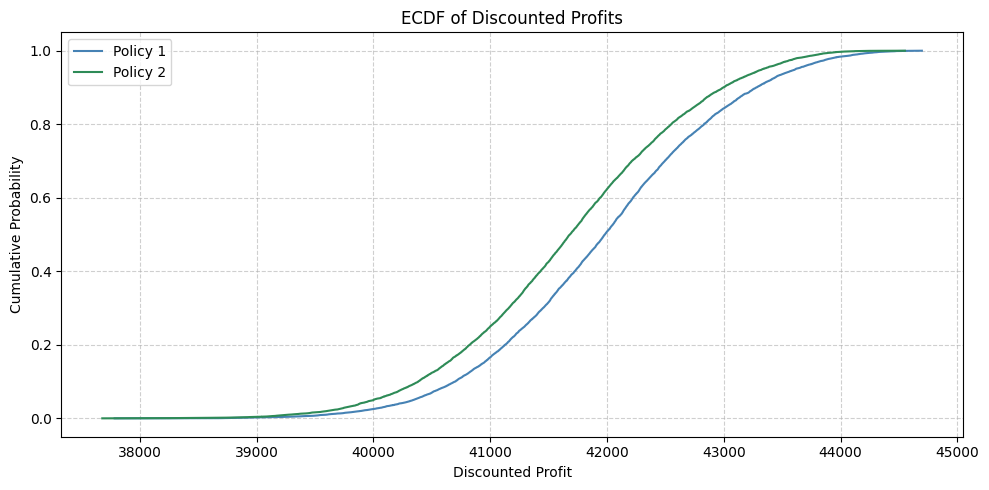

In [12]:
# === CLEAN, DIRECT COMPARISON PLOTS: POLICY 1 vs POLICY 2 ===
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Rename if needed
stats_policy1 = stats_policy1  # from simulate_forward_policy1
stats_policy2 = stats_policy2  # from simulate_forward_policy2

# --- 1. Profit Distribution Histogram ---
plt.figure(figsize=(10, 5))
plt.hist(stats_policy1["profits"], bins=30, alpha=0.6, label="Policy 1", color='steelblue')
plt.hist(stats_policy2["profits"], bins=30, alpha=0.6, label="Policy 2", color='seagreen')
plt.xlabel("Discounted Profit")
plt.ylabel("Frequency")
plt.title("Profit Distribution: Policy 1 vs Policy 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2. Overbooking Cost Histogram ---
plt.figure(figsize=(10, 5))
plt.hist(stats_policy1["costs"], bins=30, alpha=0.6, label="Policy 1", color='darkorange')
plt.hist(stats_policy2["costs"], bins=30, alpha=0.6, label="Policy 2", color='crimson')
plt.xlabel("Overbooking Cost")
plt.ylabel("Frequency")
plt.title("Overbooking Cost Distribution: Policy 1 vs Policy 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3. Boxplot: Profit Comparison ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=[stats_policy1["profits"], stats_policy2["profits"]],
            palette=['steelblue', 'seagreen'])
plt.xticks([0, 1], ['Policy 1', 'Policy 2'])
plt.ylabel("Discounted Profit")
plt.title("Boxplot of Discounted Profits")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 4. Boxplot: Overbooking Cost Comparison ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=[stats_policy1["costs"], stats_policy2["costs"]],
            palette=['darkorange', 'crimson'])
plt.xticks([0, 1], ['Policy 1', 'Policy 2'])
plt.ylabel("Overbooking Cost")
plt.title("Boxplot of Overbooking Costs")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 5. ECDF: Profit Comparison ---
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

x1, y1 = ecdf(stats_policy1["profits"])
x2, y2 = ecdf(stats_policy2["profits"])

plt.figure(figsize=(10, 5))
plt.plot(x1, y1, label="Policy 1", color='steelblue')
plt.plot(x2, y2, label="Policy 2", color='seagreen')
plt.xlabel("Discounted Profit")
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Discounted Profits")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [13]:
# === STRESS TEST: Increase show-up probability to 98% ===

# Backup original values
original_show_prob_coach = show_prob_coach
original_show_prob_fc = show_prob_fc

# Stress values
show_prob_coach = 0.98
show_prob_fc = 0.97  # You can also bump to 99% if you want

print("Running stress test with Coach show-up rate = 98%")

# Re-run forward simulations with new show-up rate
stress_stats_policy1 = simulate_forward_policy1(policy1_dict, max_coach, num_runs=10000)
stress_stats_policy2 = simulate_forward_policy2(policy2_dict, max_coach, num_runs=10000)

# Restore original values after test
show_prob_coach = original_show_prob_coach
show_prob_fc = original_show_prob_fc

# === Print Summary ===
print("\n Stress Test Results (Coach Show-Up = 98%) ")
print("Metric                         | Policy 1        | Policy 2")
print("-" * 60)
print(f"Average Profit ($)            | {stress_stats_policy1['avg_profit']:.2f}     | {stress_stats_policy2['avg_profit']:.2f}")
print(f"Std Dev of Profit             | {stress_stats_policy1['std_profit']:.2f}     | {stress_stats_policy2['std_profit']:.2f}")
print(f"Average Overbooking Cost ($) | {stress_stats_policy1['avg_cost']:.2f}     | {stress_stats_policy2['avg_cost']:.2f}")
print(f"Overbooking Frequency (%)     | {100 * stress_stats_policy1['overbook_freq']:.2f}%     | {100 * stress_stats_policy2['overbook_freq']:.2f}%")
print(f"Avg Passengers Kicked Off     | {stress_stats_policy1['avg_kicked']:.2f}     | {stress_stats_policy2['avg_kicked']:.2f}")


Running stress test with Coach show-up rate = 98%
 Starting forward simulation for Policy 1...
 Parameters: max_coach = 109, allow_no_sale = False, num_runs = 10000

  ▶️ Simulation 1 of 10000
  ▶️ Simulation 1000 of 10000
  ▶️ Simulation 2000 of 10000
  ▶️ Simulation 3000 of 10000
  ▶️ Simulation 4000 of 10000
  ▶️ Simulation 5000 of 10000
  ▶️ Simulation 6000 of 10000
  ▶️ Simulation 7000 of 10000
  ▶️ Simulation 8000 of 10000
  ▶️ Simulation 9000 of 10000
  ▶️ Simulation 10000 of 10000
 Starting forward simulation for Policy 2...
 Parameters: max_coach = 109, allow_no_sale = False, num_runs = 10000

  ▶️ Simulation 1 of 10000
  ▶️ Simulation 1000 of 10000
  ▶️ Simulation 2000 of 10000
  ▶️ Simulation 3000 of 10000
  ▶️ Simulation 4000 of 10000
  ▶️ Simulation 5000 of 10000
  ▶️ Simulation 6000 of 10000
  ▶️ Simulation 7000 of 10000
  ▶️ Simulation 8000 of 10000
  ▶️ Simulation 9000 of 10000
  ▶️ Simulation 10000 of 10000

 Stress Test Results (Coach Show-Up = 98%) 
Metric           

In [14]:
print("\n Comparison: Baseline vs Stress Test (Coach Show-Up = 98%)")
print("Metric                         | Policy 1 (Base) | Policy 1 (Stress) | Policy 2 (Base) | Policy 2 (Stress)")
print("-" * 95)
print(f"Average Profit ($)            | {stats_policy1['avg_profit']:.2f}         | {stress_stats_policy1['avg_profit']:.2f}          | {stats_policy2['avg_profit']:.2f}         | {stress_stats_policy2['avg_profit']:.2f}")
print(f"Std Dev of Profit             | {stats_policy1['std_profit']:.2f}         | {stress_stats_policy1['std_profit']:.2f}          | {stats_policy2['std_profit']:.2f}         | {stress_stats_policy2['std_profit']:.2f}")
print(f"Average Overbooking Cost ($) | {stats_policy1['avg_cost']:.2f}         | {stress_stats_policy1['avg_cost']:.2f}          | {stats_policy2['avg_cost']:.2f}         | {stress_stats_policy2['avg_cost']:.2f}")
print(f"Overbooking Frequency (%)    | {100 * stats_policy1['overbook_freq']:.2f}%       | {100 * stress_stats_policy1['overbook_freq']:.2f}%         | {100 * stats_policy2['overbook_freq']:.2f}%       | {100 * stress_stats_policy2['overbook_freq']:.2f}%")
print(f"Avg Passengers Kicked Off    | {stats_policy1['avg_kicked']:.2f}         | {stress_stats_policy1['avg_kicked']:.2f}          | {stats_policy2['avg_kicked']:.2f}         | {stress_stats_policy2['avg_kicked']:.2f}")



 Comparison: Baseline vs Stress Test (Coach Show-Up = 98%)
Metric                         | Policy 1 (Base) | Policy 1 (Stress) | Policy 2 (Base) | Policy 2 (Stress)
-----------------------------------------------------------------------------------------------
Average Profit ($)            | 41969.34         | 40765.04          | 41677.73         | 40612.35
Std Dev of Profit             | 994.19         | 866.29          | 1002.47         | 1007.32
Average Overbooking Cost ($) | 992.62         | 2187.63          | 1014.47         | 2169.18
Overbooking Frequency (%)    | 81.94%       | 99.51%         | 82.58%       | 99.54%
Avg Passengers Kicked Off    | 2.25         | 5.03          | 2.29         | 4.98


In [15]:
# === STRESS TEST: Increase show-up probability to 98% ===

# Backup original values
original_show_prob_coach = show_prob_coach
original_show_prob_fc = show_prob_fc

# Stress values
show_prob_coach = 0.95
show_prob_fc = 0.99  # You can also bump to 99% if you want

print(" Running stress test with Coach show-up rate = 98%")

# Re-run forward simulations with new show-up rate
stress_stats_policy1 = simulate_forward_policy1(policy1_dict, max_coach, num_runs=10000)
stress_stats_policy2 = simulate_forward_policy2(policy2_dict, max_coach, num_runs=10000)

# Restore original values after test
show_prob_coach = original_show_prob_coach
show_prob_fc = original_show_prob_fc

# === Print Summary ===
print("\n Stress Test Results (Coach Show-Up = 98%) ")
print("Metric                         | Policy 1        | Policy 2")
print("-" * 60)
print(f"Average Profit ($)            | {stress_stats_policy1['avg_profit']:.2f}     | {stress_stats_policy2['avg_profit']:.2f}")
print(f"Std Dev of Profit             | {stress_stats_policy1['std_profit']:.2f}     | {stress_stats_policy2['std_profit']:.2f}")
print(f"Average Overbooking Cost ($) | {stress_stats_policy1['avg_cost']:.2f}     | {stress_stats_policy2['avg_cost']:.2f}")
print(f"Overbooking Frequency (%)     | {100 * stress_stats_policy1['overbook_freq']:.2f}%     | {100 * stress_stats_policy2['overbook_freq']:.2f}%")
print(f"Avg Passengers Kicked Off     | {stress_stats_policy1['avg_kicked']:.2f}     | {stress_stats_policy2['avg_kicked']:.2f}")


 Running stress test with Coach show-up rate = 98%
 Starting forward simulation for Policy 1...
 Parameters: max_coach = 109, allow_no_sale = False, num_runs = 10000

  ▶️ Simulation 1 of 10000
  ▶️ Simulation 1000 of 10000
  ▶️ Simulation 2000 of 10000
  ▶️ Simulation 3000 of 10000
  ▶️ Simulation 4000 of 10000
  ▶️ Simulation 5000 of 10000
  ▶️ Simulation 6000 of 10000
  ▶️ Simulation 7000 of 10000
  ▶️ Simulation 8000 of 10000
  ▶️ Simulation 9000 of 10000
  ▶️ Simulation 10000 of 10000
 Starting forward simulation for Policy 2...
 Parameters: max_coach = 109, allow_no_sale = False, num_runs = 10000

  ▶️ Simulation 1 of 10000
  ▶️ Simulation 1000 of 10000
  ▶️ Simulation 2000 of 10000
  ▶️ Simulation 3000 of 10000
  ▶️ Simulation 4000 of 10000
  ▶️ Simulation 5000 of 10000
  ▶️ Simulation 6000 of 10000
  ▶️ Simulation 7000 of 10000
  ▶️ Simulation 8000 of 10000
  ▶️ Simulation 9000 of 10000
  ▶️ Simulation 10000 of 10000

 Stress Test Results (Coach Show-Up = 98%) 
Metric          

In [16]:
print("\n Comparison: Baseline vs Stress Test (Coach Show-Up = 98%)")
print("Metric                         | Policy 1 (Base) | Policy 1 (Stress) | Policy 2 (Base) | Policy 2 (Stress)")
print("-" * 95)
print(f"Average Profit ($)            | {stats_policy1['avg_profit']:.2f}         | {stress_stats_policy1['avg_profit']:.2f}          | {stats_policy2['avg_profit']:.2f}         | {stress_stats_policy2['avg_profit']:.2f}")
print(f"Std Dev of Profit             | {stats_policy1['std_profit']:.2f}         | {stress_stats_policy1['std_profit']:.2f}          | {stats_policy2['std_profit']:.2f}         | {stress_stats_policy2['std_profit']:.2f}")
print(f"Average Overbooking Cost ($) | {stats_policy1['avg_cost']:.2f}         | {stress_stats_policy1['avg_cost']:.2f}          | {stats_policy2['avg_cost']:.2f}         | {stress_stats_policy2['avg_cost']:.2f}")
print(f"Overbooking Frequency (%)    | {100 * stats_policy1['overbook_freq']:.2f}%       | {100 * stress_stats_policy1['overbook_freq']:.2f}%         | {100 * stats_policy2['overbook_freq']:.2f}%       | {100 * stress_stats_policy2['overbook_freq']:.2f}%")
print(f"Avg Passengers Kicked Off    | {stats_policy1['avg_kicked']:.2f}         | {stress_stats_policy1['avg_kicked']:.2f}          | {stats_policy2['avg_kicked']:.2f}         | {stress_stats_policy2['avg_kicked']:.2f}")



 Comparison: Baseline vs Stress Test (Coach Show-Up = 98%)
Metric                         | Policy 1 (Base) | Policy 1 (Stress) | Policy 2 (Base) | Policy 2 (Stress)
-----------------------------------------------------------------------------------------------
Average Profit ($)            | 41969.34         | 41867.06          | 41677.73         | 41705.06
Std Dev of Profit             | 994.19         | 999.75          | 1002.47         | 1126.76
Average Overbooking Cost ($) | 992.62         | 1078.19          | 1014.47         | 1080.26
Overbooking Frequency (%)    | 81.94%       | 80.87%         | 82.58%       | 81.44%
Avg Passengers Kicked Off    | 2.25         | 2.48          | 2.29         | 2.48


In [17]:
41989.29-40750.07

1239.2200000000012

In [18]:
41687.46-40621.80

1065.6599999999962